# Chapter 2 자연어와 단어의 분산 표현

이번 장의 주제 : **컴퓨터에게 '단어의 의미' 이해시키기** $\rightarrow$ '단어의 의미'를 잘 파악하는 표현 방법  
- 시소러스를 활용한 기법 (Ch.2)
- 통계 기반 기법 (Ch.2)
- 추론 기반 기법 (word2vec) (Ch.3)

## 2.3 통계 기반 기법

#### **말뭉치**란?  
  
대량의 텍스트 데이터.  
맹목적으로 수집된 데이터가 아닌 자연어 처리 연구나 애플리케이션을 염두에 두고 수집된 텍스트 데이터를 말합니다.  
**말뭉치**를 이용해 통계 기반 기법을 살펴볼 예정.

### 2.3.1 파이썬으로 말뭉치 전처리하기

In [2]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
print(text)

In [6]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [7]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [8]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [9]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [10]:
id_to_word[1]

'say'

In [11]:
import numpy as np
corpus = [word_to_id[w] for w in words]

In [12]:
corpus

[0, 1, 2, 3, 4, 1, 5, 6]

In [14]:
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

#### preprocess() 함수

In [15]:
def preprocess(text):
    text = text.lower()
    text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [16]:
text = 'You say goodbye and I say hello.'

In [17]:
preprocess(text)

(array([0, 1, 2, 3, 4, 1, 5]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello.': 5},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello.'})

### 2.3.4 동시발생 행렬

In [28]:
# p.88
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

In [35]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [36]:
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [37]:
# p.91
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

### 2.3.5 벡터 간 유사도

단어 벡터의 유사도를 나타낼 때는 **코사인 유사도**를 자주 이용

<p align='center'><img src='./master/images/e 2-1.png' width=500>

In [33]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx, ny)

In [34]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0 ,c1))

0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시

어떤 단어가 검색어로 주어지면, 그 검색어와 비슷한 단어를 유사도 순으로 출력

In [38]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5): # word_matrix는 동시발생 행렬 같은 것들
    # (1) 검색어를 꺼낸다.
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return
    
    print("\n[query] " + query)
    query_id = word_to_id[query] # query의 id 저장
    query_vec = word_matrix[query_id] # 동시발생 행렬에는 각 단어의 id로 벡터들이 저장돼있음
    
    # (2) 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # (3) 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f"{id_to_word[i]}: {similarity[i]}")
        
        count += 1
        if count>= top:
            return

In [40]:
import sys 
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar("you", word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선하기

### 2.4.1 상호정보량
**점별 상호정보량(Pointwise Mutual Information)**  
$$ PMI(x, y) = \log_{2} \frac{P(x, y)}{P(x)P(y)} = \log_{2} \frac{\frac{C(x, y)}{N}}{\frac{C(x)}{N} \frac{C(y)}{N}} = \log_{2} \frac{C(x, y) \cdot N}{C(x) C(y)}$$  
- $P(x)$ : $x$가 일어날 확률  
- $P(y)$ : $y$가 일어날 확률  
- $P(x, y)$ : $x$와 $y$가 동시에 일어날 확률  
- $C$ : 동시발생 행렬
- $C(x, y)$ : 단어 $x$와 $y$가 동시발생하는 횟수
- $C(x)$ : $x$의 등장 횟수
- $N$ : `corpus`에 포함된 단어 수  
  
하지만 $C(x, y) = 0 $ 일 때 $PMI$ 값이 $ - \infty$ 가 되는 문제가 있다.  



**양의 상호정보량(Positive PMI)**  
$$ PPMI(x, y) = max(0, PMI(x, y)) $$  

$PMI$ 를 보완한다. 

In [41]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print(f"{100*cnt/total:.1f}% 완료")
                    
    return M

In [43]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표시
print("동시발생 행렬")
print(C)
print("-"*50)
print("PPMI")
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI 행렬은 살펴보면 대부분의 원소가 0인 것을 알 수 있습니다.  
이런 벡터는 노이즈에 약하고 견고하지 못하다는 약점이 있습니다.  
이 문제에 대처하고자 자주 수행하는 기법이 **벡터의 차원 감소**입니다.

### 2.4.2 차원 감소

**차원 감소(Dimensionality reduction)** 은 벡터의 차원을 줄이는 방법을 말합니다.  
'중요한 정보'는 최대한 유지하면서 줄이는 게 핵심입니다.

여기서는 **특잇값분해(Singular Value Decomposition)(SVD)**를 이용합니다.  
SVD는 임의의 행렬을 세 행렬의 곱으로 분해합니다.  
$$ X = USV^{T} $$  
- $U$, $V$ : 직교행렬 (Orthogonal matrix)
- $S$ : 대각행렬 (Diagonal matrix)  

<p align='center'><img src="./master/images/fig 2-9.png" width=500/>

- $U$ : 어떠한 공간의 축(기저)을 형성. '단어 공간'으로 취급할 수 있다. 
- $S$ : 대각 성분에는 '특잇값(singular value)'이 큰 순서로 나열되어 있다.  
  - 특잇값이란? '해당 축'의 중요도

### 2.4.3 SVD에 의한 차원 감소

In [44]:
import sys 
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = "You say goodbye and I say hello."

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [45]:
print(C[0])

print(W[0])

print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-3.409e-01 -1.110e-16 -4.441e-16  1.205e-01  9.323e-01  0.000e+00
  3.207e-16]


In [48]:
print(U[0, :2])

[-3.409e-01 -1.110e-16]


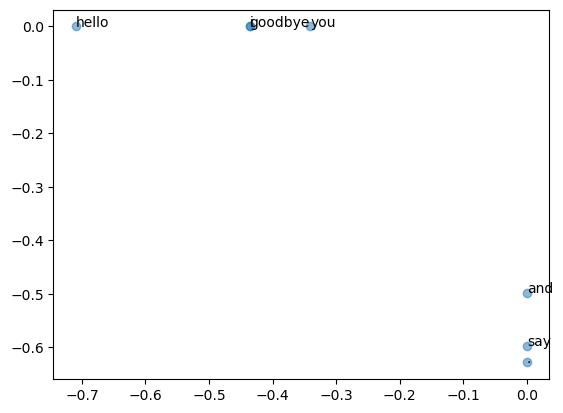

In [50]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### 2.4.4 PTB 데이터셋

**펜 트리뱅크(Penn Treebank)**